In [1]:
import math 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random

### Understanding Derivatives : single and multiple input case

In [2]:
def f(x):
    return 3*x**2-4*x+5

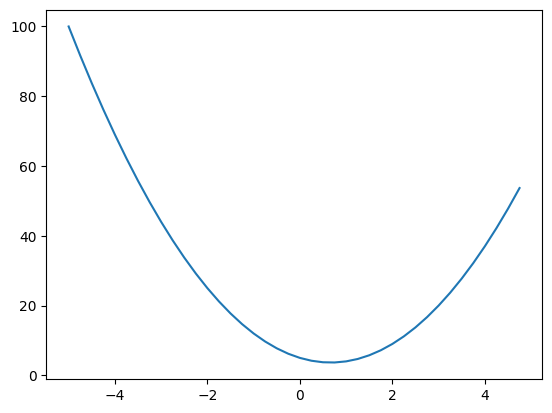

In [3]:
xs=np.arange(-5,5,0.25)
ys=f(xs)
plt.plot(xs,ys)

In [4]:
h=0.00001
x=2/3
(f(x+h)-f(x))/h #slope

3.0000002482211127e-05

In [5]:
# The multiple input case
a=2.0
b=-3.0
c=10.0
d=a*b+c
print(d)

4.0


In [6]:
h=0.001

#inputs
a=2.0
b=-3.0
c=10.0

d1=a*b+c
a+=h
d2=a*b+c

print('d1',d1)
print('d2',d2)
print('slope',(d2-d1)/h)

d1 4.0
d2 3.997
slope -3.0000000000001137


### Micrograd :The Value Object

In [7]:
class Value:
    def __init__(self,data,_children=(),_op='',label=''):
        self.data=data
        self.grad=0.0
        self._backward = lambda: None
        self._prev=set(_children)
        self._op=_op
        self.label=label
        
        
    def __repr__(self): #for an innformative output
        return f"Value(data={self.data})"

    def __add__(self,other):
        other=other if isinstance(other,Value) else Value(other)
        out=Value(self.data+other.data,(self,other),'+')
        def _backward():
            self.grad+=1.0*out.grad
            other.grad+=1.0*out.grad
        out._backward=_backward
            
        return out
        
    def __mul__(self,other):
        other=other if isinstance(other,Value) else Value(other)
        out=Value(self.data*other.data,(self,other),'*')
        def _backward():
            self.grad+=other.data*out.grad
            other.grad+=self.data*out.grad
        out._backward=_backward
        return out
        
    def __pow__(self,other):
        assert isinstance(other,(int,float))
        out=Value(self.data**other,(self,),f'**{other}')

        def _backward():
            self.grad+=other*(self.data**(other-1))*out.grad
        out._backward=_backward
        return out
    
    def __rmul__(self,other):#other = self
        return self*other
        
    def __radd__(self,other):#other = self
        return self + other
    def __truediv__(self,other):#self/other
        return self*(other**-1)

    def __neg__(self):
        return self*-1

    def __sub__(self,other):#self-other
        return self + (-other)
        
    #tanh function
    def tanh(self):
        x=self.data
        t=((math.exp(2*x)-1)/(math.exp(2*x)+1)) 
        out=Value(t,(self,),'tanh')
        def _backward():
            self.grad+=1-t**2
        out._backward=_backward
        return out

    #exponential function
    def exp(self):
        x=self.data
        out=Value(math.exp(x),(self,),'exp')
        def _backward():
            self.grad+=out.data*out.grad
        out._backward=_backward
        return out

    
    
    def backward(self):     
        topo=[]
        visited=set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad=1.0
        for node in reversed(topo):
            node._backward()
    
a=Value(2.0,label='a')
b=Value(-3.0,label='b')
c=Value(10,label='c')
e=a*b;e.label='e'
d=e+c;d.label='d'
f=Value(-2.0,label='f')
L=d*f;L.label='L'


In [8]:
1+a

Value(data=3.0)

In [9]:
!pip install graphviz

## To Create the Computation Graph

In [10]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{%s |  data %.4f | grad%.4f }" % (n.label, n.data,n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


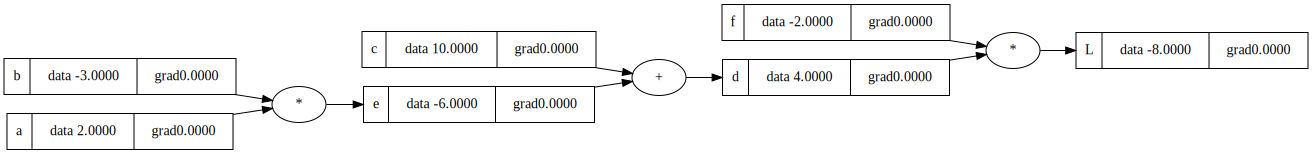

In [11]:
draw_dot(L)

In [12]:
L.grad=1
d.grad=f.data
f.grad=d.data
c.grad=d.grad*1
e.grad=d.grad*1
b.grad=a.data*e.grad
a.grad=b.data*e.grad

In [13]:
  #function to calculate gradient 

def grad_calc():
    h=0.0001
    a=Value(2.0,label='a')
    b=Value(-3.0,label='b')
    c=Value(10,label='c')
    e=a*b;e.label='e'
    d=e+c;d.label='d'
    f=Value(-2.0,label='f')
    L=d*f;L.label='L'
    L1=L.data

    #add h to bum values of varaibles
    a=Value(2.0,label='a')
    b=Value(-3.0+h,label='b')
    c=Value(10,label='c')
    e=a*b;e.label='e'
    d=e+c;d.label='d'
    f=Value(-2.0,label='f')
    L=d*f;L.label='L'
    L2=L.data

    print((L2-L1)/h)

grad_calc()

-4.000000000008441


## BackProp Using Neurons

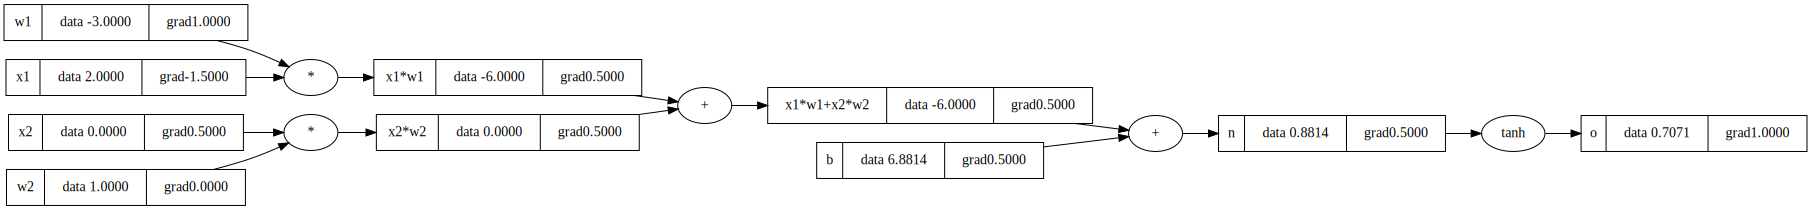

In [14]:
#backprop using neurons
#inputs
x1=Value(2.0,label='x1')
x2=Value(0.0,label='x2')

#weights
w1=Value(-3.0,label='w1')
w2=Value(1.0,label='w2')

#bias
b=Value(6.88137,label='b')

x1w1=x1*w1;x1w1.label='x1*w1';
x2w2=x2*w2;x2w2.label='x2*w2';

x1w1x2w2=x1w1+x2w2;x1w1x2w2.label='x1*w1+x2*w2';
n=x1w1x2w2+b;n.label='n'
o=n.tanh();o.label='o'
o.backward()
draw_dot(o)

In [15]:
#filling in all the gradients manually
o.grad=1.0
n.grad=1-o.data**2
b.grad=n.grad
x1w1x2w2.grad=n.grad
x1w1.grad=x1w1x2w2.grad
x2w2.grad=x1w1x2w2.grad
w1.grad=x1.data*x1w1.grad
x1.grad=w1.data*x1w1.grad
w2.grad=x2.data*x2w2.grad
x2.grad=w2.data*x2w2.grad


In [16]:
o.grad=1

In [17]:

o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

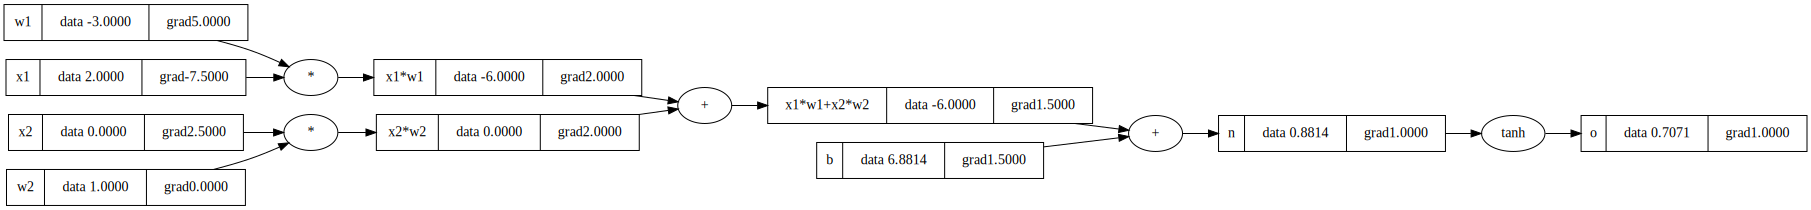

In [18]:
draw_dot(o)

In [19]:
#implementing backward for the whole expression graph using topological sort
o.grad=1.0
topo=[]
visited=set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)

for node in reversed(topo):
    node._backward()
    


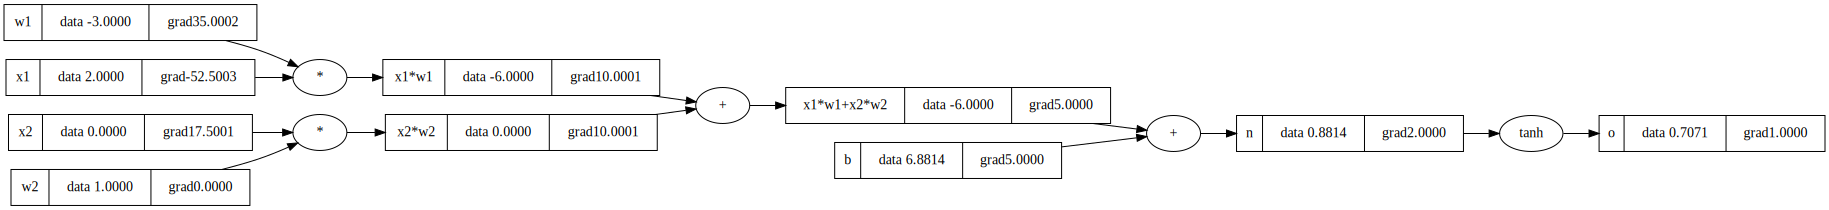

In [20]:
o.backward()
draw_dot(o)

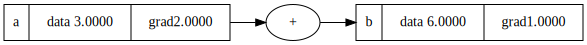

In [21]:
#bug fixing 
a=Value(3.0,label='a')
b=a+a;b.label='b';
b.backward()
draw_dot(b)
#here the grad of b wrt to a should be 2

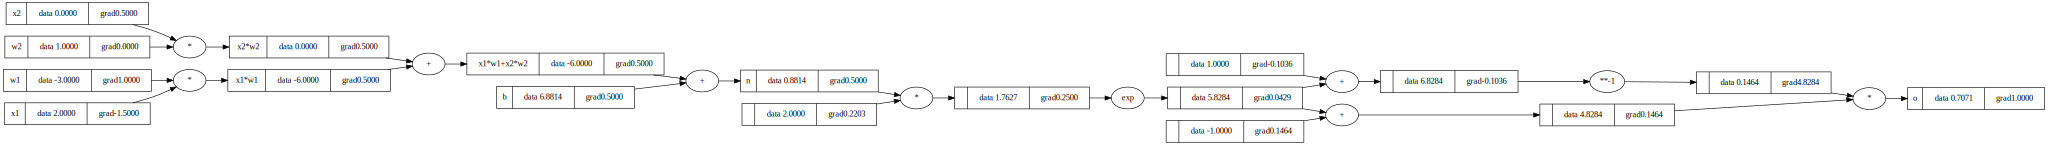

In [22]:
#backprop using neurons with tanh split up
#inputs
x1=Value(2.0,label='x1')
x2=Value(0.0,label='x2')

#weights
w1=Value(-3.0,label='w1')
w2=Value(1.0,label='w2')

#bias
b=Value(6.88137,label='b')

x1w1=x1*w1;x1w1.label='x1*w1';
x2w2=x2*w2;x2w2.label='x2*w2';

x1w1x2w2=x1w1+x2w2;x1w1x2w2.label='x1*w1+x2*w2';
n=x1w1x2w2+b;n.label='n'
e=(2*n).exp();
o=(e-1)/(e+1);
o.label='o'
o.backward()
draw_dot(o)

In [23]:
#same thing but in pytorch 
import torch

# Create tensors with requires_grad=True
x1 = torch.tensor([2.0], dtype=torch.double, requires_grad=True)
x2 = torch.tensor([0.0], dtype=torch.double, requires_grad=True)
w1 = torch.tensor([-3.0], dtype=torch.double, requires_grad=True)
w2 = torch.tensor([1.0], dtype=torch.double, requires_grad=True)
b  = torch.tensor([6.8813735870195432], dtype=torch.double, requires_grad=True)

# Forward pass
n = x1 * w1 + x2 * w2 + b
o = torch.tanh(n)

# Print output
print(o.data.item())

# Backward pass
o.backward()

# Print gradients
print('---')
print('x2\'s grad:', x2.grad.item())
print('w2\'s grad:', w2.grad.item())
print('x1\'s grad:', x1.grad.item())
print('w1\'s grad:', w1.grad.item())


0.7071067811865476
---
x2's grad: 0.49999999999999994
w2's grad: 0.0
x1's grad: -1.4999999999999998
w1's grad: 0.9999999999999999


In [24]:
o.data.item()

0.7071067811865476

### Building the Neuron, Layer and MLP using the Value object built above

In [25]:
class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]




x=[2.0,3.0,-1.0]
n=MLP(3,[4,4,1])
n(x)

Value(data=-0.07207849283489125)

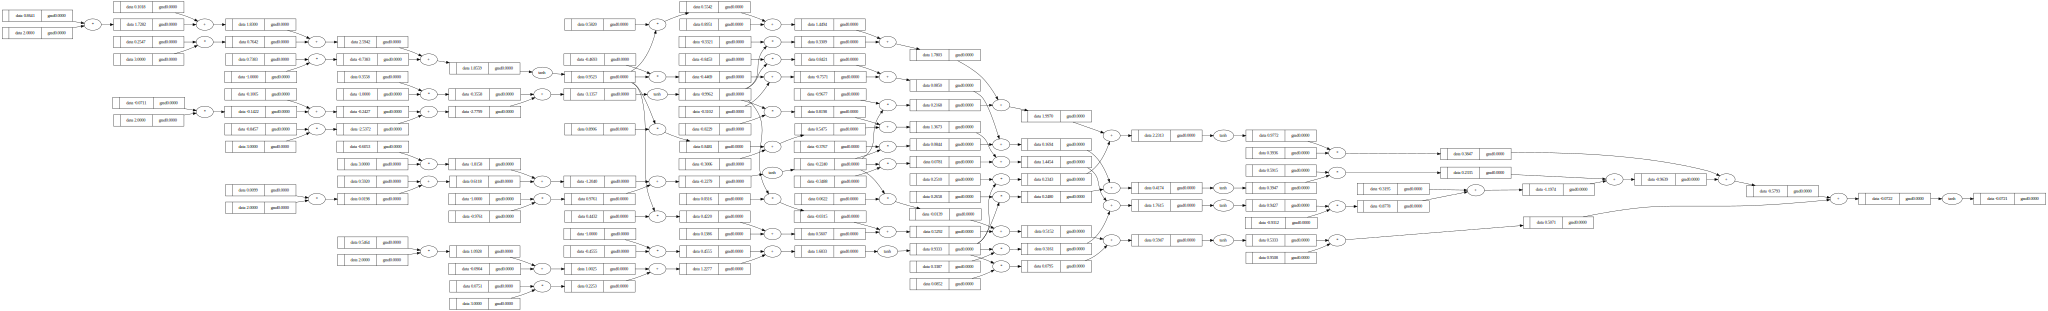

In [26]:
draw_dot(n(x))

In [27]:

#Data
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets



In [28]:
for k in range(20):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update (gradient Descent)
  for p in n.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)
  

0 3.8669840454635334
1 7.399420723338028
2 6.697267797307788
3 5.442470236300965
4 7.370644769161791
5 7.5504329780635775
6 7.503846617193128
7 7.660906033623861
8 7.755657585105858
9 7.808074846799567
10 7.8415085675745075
11 7.864774697392306
12 7.881941741527662
13 7.895153021011778
14 7.905647807881995
15 7.914193907949052
16 7.921293106440942
17 7.927287579539966
18 7.932418899641398
19 7.9368626069192985


In [29]:
ypred  #predictions 

[Value(data=-0.9920832118486393),
 Value(data=-0.9920806959420663),
 Value(data=-0.9920777284717177),
 Value(data=-0.9920696790592387)]